In [72]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [73]:
%cd /gdrive/MyDrive/AN2DL/Homework1/

/gdrive/MyDrive/AN2DL/Homework1


### Import Libraries

In [74]:
import os
import numpy as np
import tensorflow as tf
import random
from PIL import Image
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [75]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

### Set seed for reproducibility

In [76]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Leaf Dataset

In [77]:
full_dataset_dir = 'full_dataset'
#!unzip dataset.zip
#os.rename('training',full_dataset_dir)

In [78]:
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

### Data Preprocessing

Done in the other notebook

### Data Loader

In [80]:
sub_dataset_dir = 'training_validation_testing'
training_dir = os.path.join(sub_dataset_dir, 'training')
validation_dir = os.path.join(sub_dataset_dir, 'validation')
test_dir = os.path.join(sub_dataset_dir, 'testing')

In [81]:
from PIL import Image, ImageFilter, ImageEnhance

def transformation(imageArray):
  image = Image.fromarray(np.reshape(imageArray, (256,256)).astype(np.uint8), 'L')
  image = image.filter(ImageFilter.EDGE_ENHANCE)
  image = image.filter(ImageFilter.FIND_EDGES)

  for i in range(4):
    image = image.filter(ImageFilter.SMOOTH)
    image = image.filter(ImageFilter.MedianFilter)
    image = ImageEnhance.Contrast(image).enhance(2)

  image = image.convert('1')
  imageArray = np.array(image, dtype=np.bool)

  return np.reshape(imageArray, (256, 256, 1))

In [82]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
# Create an instance of ImageDataGenerator with Data Augmentation
train_data_gen = ImageDataGenerator(#preprocessing_function=transformation,
                                    rotation_range=30,
                                    height_shift_range=50,
                                    width_shift_range=50,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='reflect', #)
                                    rescale=1/255.) # rescale value is multiplied to the image

valid_data_gen = ImageDataGenerator(rescale=1/255.)#,
                                    #preprocessing_function=transformation)

test_data_gen = ImageDataGenerator(rescale=1/255.)#,
                                    #preprocessing_function=transformation)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               color_mode='grayscale',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='grayscale',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='grayscale',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 10629 images belonging to 14 classes.
Found 3547 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [83]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


### Model Metadata

In [84]:
# Model configuration
input_shape = (256, 256, 1)
epochs = 100
batch_size = 64
n_classes = 14
weight_decay = 1e-5
model_name = "CNN_gap_64"

### CNN Model

* Batch Norm
* Early Stopping
* Batch
* Increasing Dropout
* Weight Decay
* Weight Initialization
* Data Augmentation

In [85]:
# Model used for the exercise:
# (Conv + ReLU + MaxPool) x 4 + (Conv + ReLU + GlobalPooling) x 1 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
    )(input_layer)
    batch_norm1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(batch_norm1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
    )(pool1)
    batch_norm2 = tfkl.BatchNormalization()(conv2)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(batch_norm2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
    )(pool2)
    batch_norm3 = tfkl.BatchNormalization()(conv3)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(batch_norm3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
    )(pool3)
    batch_norm4 = tfkl.BatchNormalization()(conv4)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(batch_norm4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
    )(pool4)
    batch_norm5 = tfkl.BatchNormalization()(conv5)
    globalPool = tfkl.GlobalAveragePooling2D()(batch_norm5)

    flattening_layer = tfkl.Flatten(name='Flatten')(globalPool)
    flattening_layer = tfkl.Dropout(0.25, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    batch_norm6 = tfkl.BatchNormalization()(classifier_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(batch_norm6)
    output_layer = tfkl.Dense(units=n_classes, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [86]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 256, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_13 (Bat  (None, 128, 128, 32)     128   

In [87]:
#tfk.utils.plot_model(model)

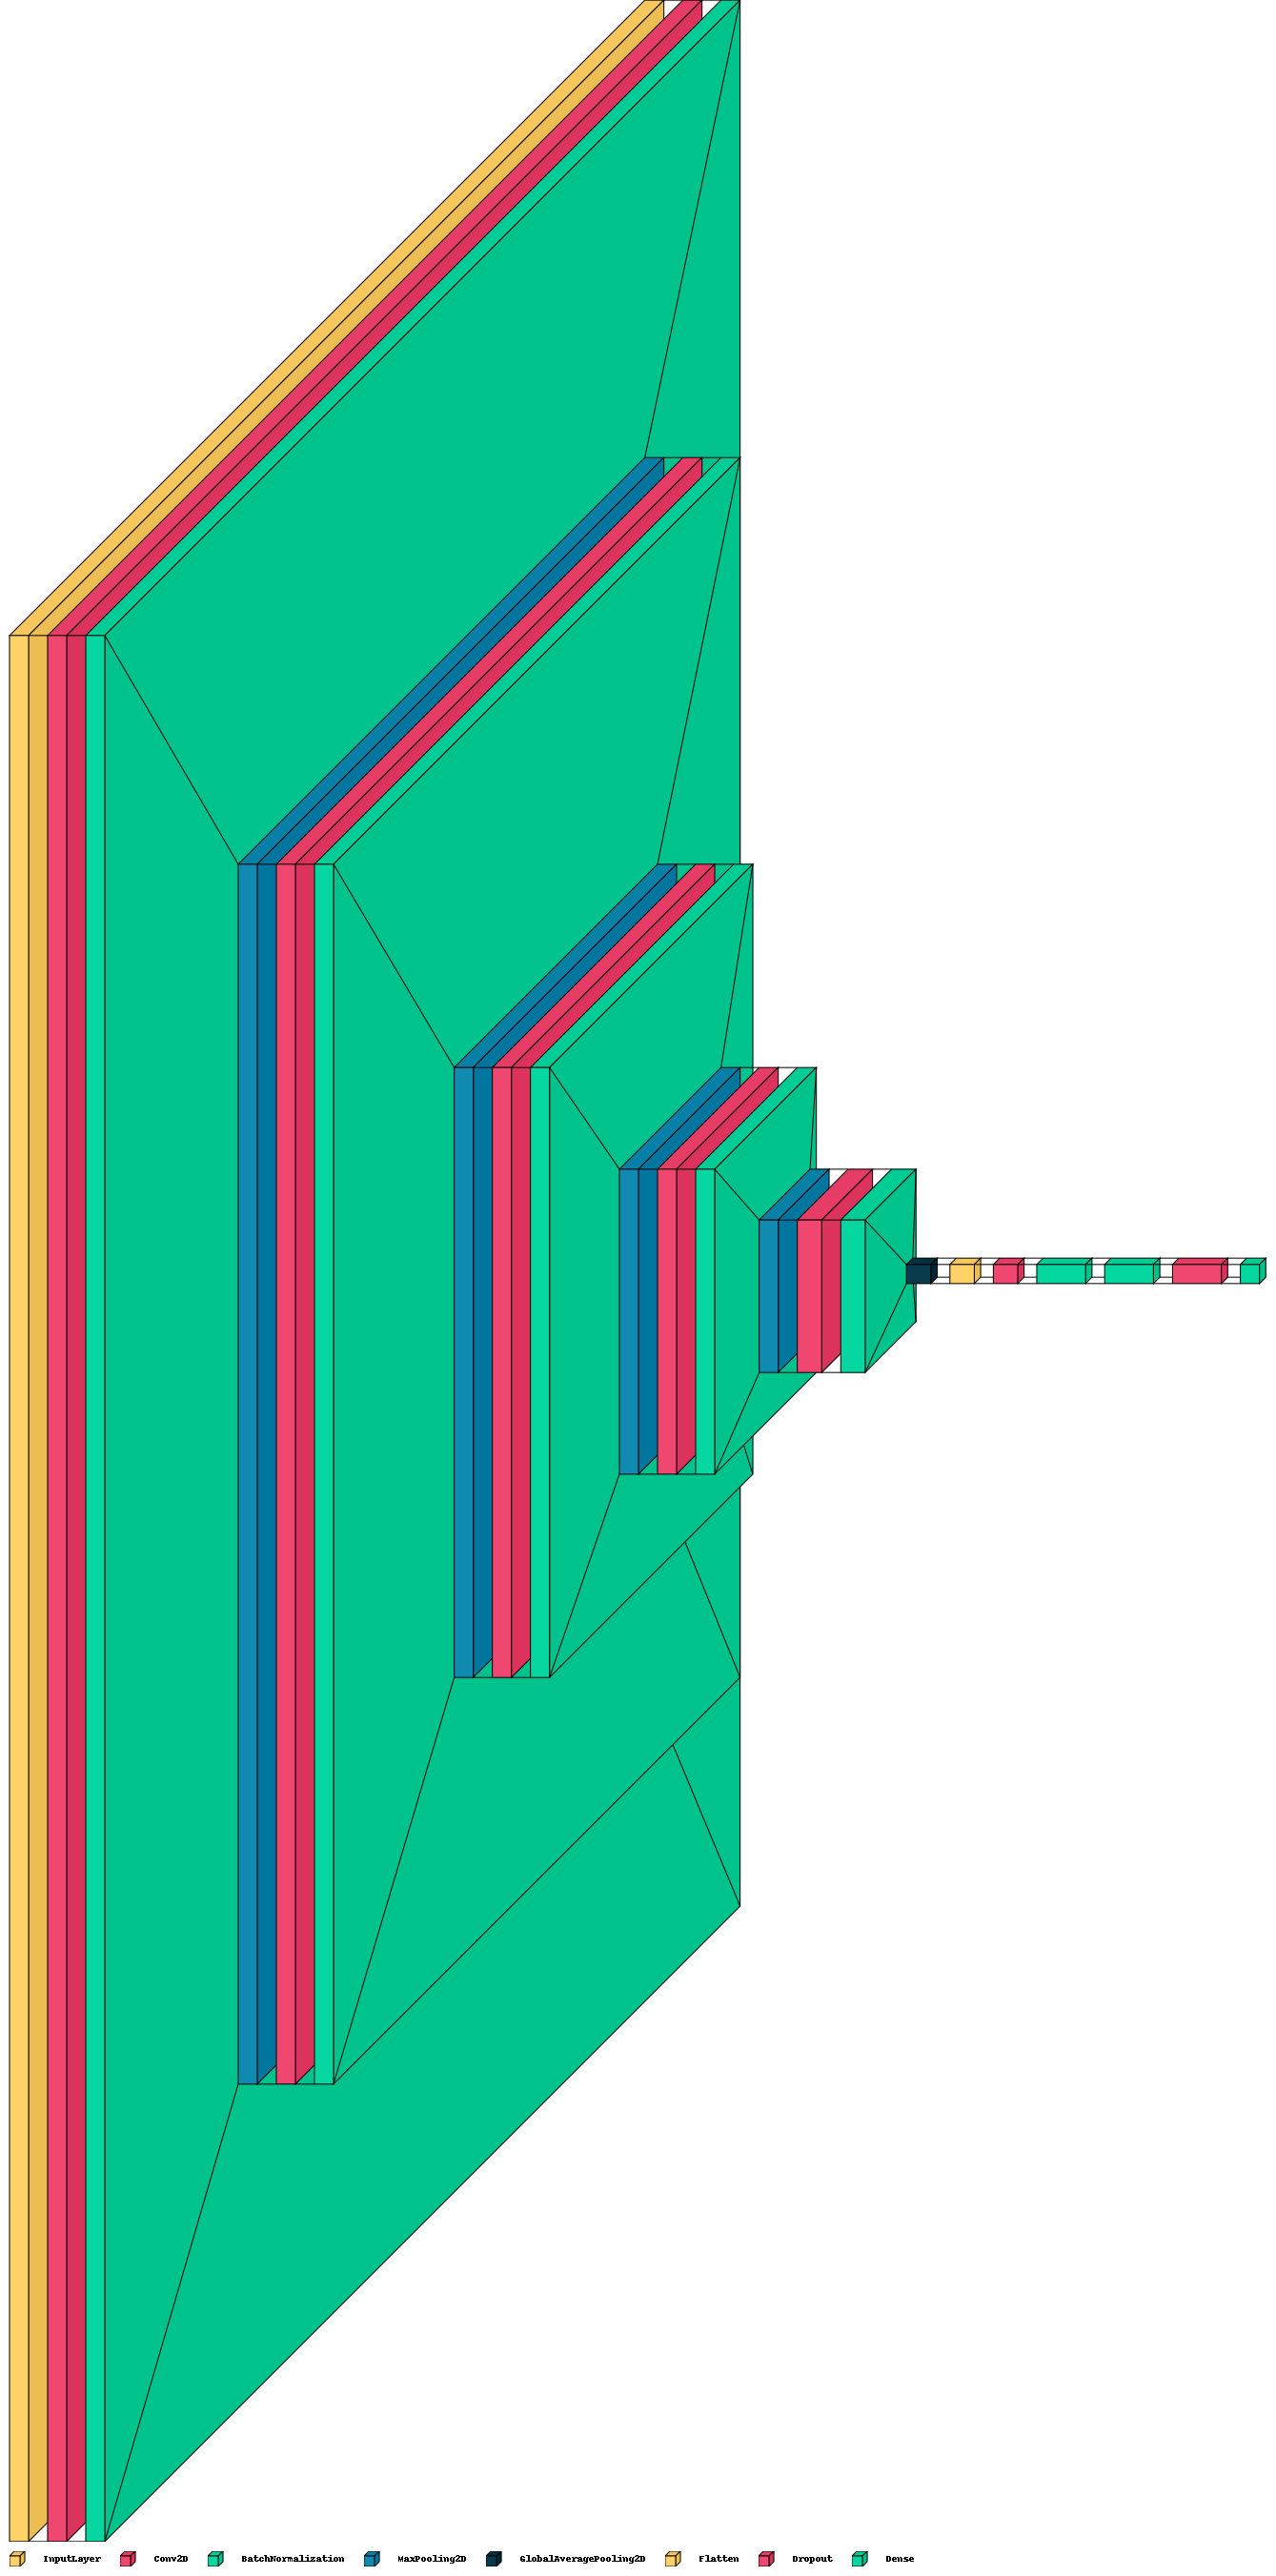

In [88]:
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

### Training

In [89]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('models')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [90]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name=model_name)

# Train the model
history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[callbacks]
).history

Epoch 1/100
1329/1329 [==============================] - ETA: 0s - loss: 2.1380 - accuracy: 0.4014

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 1489s 1s/step - loss: 2.1380 - accuracy: 0.4014 - val_loss: 1.6548 - val_accuracy: 0.4844
Epoch 2/100
1329/1329 [==============================] - ETA: 0s - loss: 1.5367 - accuracy: 0.5194

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 153s 115ms/step - loss: 1.5367 - accuracy: 0.5194 - val_loss: 1.8583 - val_accuracy: 0.3958
Epoch 3/100
1329/1329 [==============================] - ETA: 0s - loss: 1.2068 - accuracy: 0.6165

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 153s 115ms/step - loss: 1.2068 - accuracy: 0.6165 - val_loss: 2.1356 - val_accuracy: 0.4314
Epoch 4/100
1329/1329 [==============================] - ETA: 0s - loss: 1.0215 - accuracy: 0.6806

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 153s 115ms/step - loss: 1.0215 - accuracy: 0.6806 - val_loss: 1.5299 - val_accuracy: 0.5379
Epoch 5/100
1329/1329 [==============================] - ETA: 0s - loss: 0.8708 - accuracy: 0.7246

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 154s 116ms/step - loss: 0.8708 - accuracy: 0.7246 - val_loss: 1.9693 - val_accuracy: 0.5782
Epoch 6/100
1329/1329 [==============================] - ETA: 0s - loss: 0.7684 - accuracy: 0.7566

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 154s 116ms/step - loss: 0.7684 - accuracy: 0.7566 - val_loss: 3.4673 - val_accuracy: 0.4714
Epoch 7/100
1329/1329 [==============================] - ETA: 0s - loss: 0.7114 - accuracy: 0.7737

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 150s 113ms/step - loss: 0.7114 - accuracy: 0.7737 - val_loss: 0.5476 - val_accuracy: 0.8337
Epoch 8/100
1329/1329 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.7989

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 154s 116ms/step - loss: 0.6324 - accuracy: 0.7989 - val_loss: 4.3268 - val_accuracy: 0.3569
Epoch 9/100
1329/1329 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.8227

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 152s 115ms/step - loss: 0.5927 - accuracy: 0.8227 - val_loss: 1.4381 - val_accuracy: 0.6262
Epoch 10/100
1329/1329 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.8323

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 152s 115ms/step - loss: 0.5573 - accuracy: 0.8323 - val_loss: 0.6883 - val_accuracy: 0.8021
Epoch 11/100
1329/1329 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.8379

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 152s 114ms/step - loss: 0.5349 - accuracy: 0.8379 - val_loss: 0.5461 - val_accuracy: 0.8472
Epoch 12/100
1329/1329 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.8535

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 152s 115ms/step - loss: 0.4979 - accuracy: 0.8535 - val_loss: 0.3821 - val_accuracy: 0.8960
Epoch 13/100
1329/1329 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.8580

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 152s 114ms/step - loss: 0.4805 - accuracy: 0.8580 - val_loss: 0.6960 - val_accuracy: 0.8080
Epoch 14/100
1329/1329 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.8691

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 153s 115ms/step - loss: 0.4621 - accuracy: 0.8691 - val_loss: 0.4309 - val_accuracy: 0.8838
Epoch 15/100
1329/1329 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8726

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 150s 113ms/step - loss: 0.4405 - accuracy: 0.8726 - val_loss: 0.4686 - val_accuracy: 0.8700
Epoch 16/100
1329/1329 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8734

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 147s 111ms/step - loss: 0.4338 - accuracy: 0.8734 - val_loss: 0.2457 - val_accuracy: 0.9385
Epoch 17/100
1329/1329 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8799

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 147s 111ms/step - loss: 0.4293 - accuracy: 0.8799 - val_loss: 0.4733 - val_accuracy: 0.8745
Epoch 18/100
1329/1329 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.8869

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 149s 112ms/step - loss: 0.4043 - accuracy: 0.8869 - val_loss: 0.3735 - val_accuracy: 0.9047
Epoch 19/100
1329/1329 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8841

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 148s 111ms/step - loss: 0.4076 - accuracy: 0.8841 - val_loss: 0.8338 - val_accuracy: 0.8007
Epoch 20/100
1329/1329 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8922

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 148s 111ms/step - loss: 0.3869 - accuracy: 0.8922 - val_loss: 0.3414 - val_accuracy: 0.9087
Epoch 21/100
1329/1329 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8952

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 148s 111ms/step - loss: 0.3927 - accuracy: 0.8952 - val_loss: 1.9269 - val_accuracy: 0.6927
Epoch 22/100
1329/1329 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8981

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 150s 113ms/step - loss: 0.3837 - accuracy: 0.8981 - val_loss: 0.3417 - val_accuracy: 0.9064
Epoch 23/100
1329/1329 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8998

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 149s 112ms/step - loss: 0.3682 - accuracy: 0.8998 - val_loss: 0.4252 - val_accuracy: 0.8917
Epoch 24/100
1329/1329 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8990

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 149s 112ms/step - loss: 0.3853 - accuracy: 0.8990 - val_loss: 0.7740 - val_accuracy: 0.8024
Epoch 25/100
1329/1329 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.9041

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 149s 112ms/step - loss: 0.3675 - accuracy: 0.9041 - val_loss: 0.3778 - val_accuracy: 0.9016
Epoch 26/100
1329/1329 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.9086

INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_Nov15_18-51-08/ckpts/cp.ckpt/assets


1329/1329 [==============================] - 150s 113ms/step - loss: 0.3593 - accuracy: 0.9086 - val_loss: 0.3748 - val_accuracy: 0.9087


In [91]:
# Save best epoch model
model.save("models/" + model_name + "_best_" + str(datetime.now().strftime('%b%d_%H-%M-%S')))

INFO:tensorflow:Assets written to: models/CNN_gap_128_best_Nov15_20-18-45/assets


INFO:tensorflow:Assets written to: models/CNN_gap_128_best_Nov15_20-18-45/assets


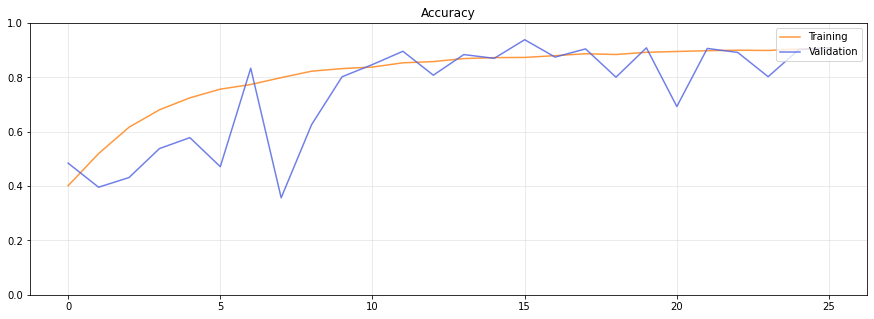

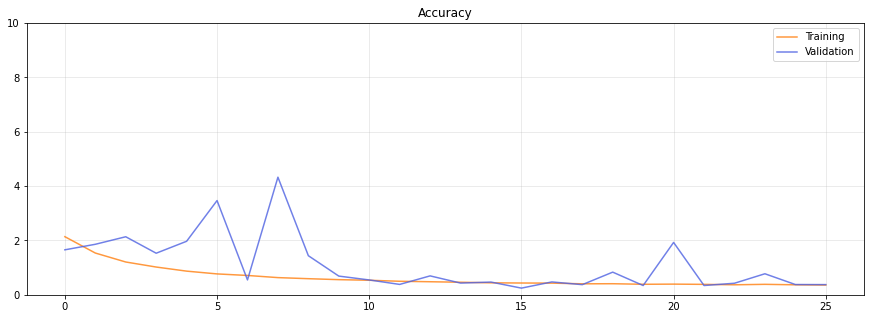

In [97]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 10)
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)

plt.show()

### Testing

In [93]:
# Evaluate on test
model_test_metrics = model.evaluate(test_gen, return_dict=True)

print()
print(model_test_metrics)

444/444 [==============================] - 426s 962ms/step - loss: 0.2606 - accuracy: 0.9386

{'loss': 0.26057925820350647, 'accuracy': 0.9386261105537415}
